In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import shutil
import random
import cv2
import numpy as np
from tqdm import tqdm # Thư viện tạo thanh tiến trình

# --- CẤU HÌNH ---
INPUT_DIR = '/kaggle/input/gkhocsau/DatasetMod'  # Folder gốc
OUTPUT_DIR = '/kaggle/working/Processed_Dataset' # Folder đích
TARGET_SIZE = 224 
VAL_RATIO = 0.3  # 30% dữ liệu để test 

def process_and_split():
    # 1. Xóa folder cũ nếu có để làm sạch
    if os.path.exists(OUTPUT_DIR):
        shutil.rmtree(OUTPUT_DIR)
    
    # 2. Tạo cấu trúc folder train/val
    train_dir = os.path.join(OUTPUT_DIR, 'train')
    val_dir = os.path.join(OUTPUT_DIR, 'val')
    os.makedirs(train_dir)
    os.makedirs(val_dir)

    classes = os.listdir(INPUT_DIR)
    total_files = 0

    print("Đang chia tách và xử lý ảnh...")
    
    for class_name in classes:
        class_path = os.path.join(INPUT_DIR, class_name)
        if not os.path.isdir(class_path): continue

        # Tạo folder class trong train và val
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        # Lấy danh sách ảnh
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(images) # Xáo trộn ngẫu nhiên

        # Tính số lượng split
        num_val = int(len(images) * VAL_RATIO)
        # Đảm bảo ít nhất 1 ảnh validation nếu folder có ảnh
        if num_val == 0 and len(images) > 1: 
            num_val = 1
            
        val_files = images[:num_val]
        train_files = images[num_val:]

        # Hàm copy và resize
        def copy_and_resize(files, src_root, dest_root):
            for file_name in files:
                src = os.path.join(src_root, file_name)
                dest = os.path.join(dest_root, file_name)
                
                # Đọc và resize (Letterbox để giữ tỉ lệ hoặc resize thẳng)
                
                
                img = cv2.imread(src)
                if img is not None:
                    img = cv2.resize(img, (TARGET_SIZE, TARGET_SIZE))
                    cv2.imwrite(dest, img)

        # Thực thi copy
        copy_and_resize(train_files, class_path, os.path.join(train_dir, class_name))
        copy_and_resize(val_files, class_path, os.path.join(val_dir, class_name))
        
        total_files += len(images)

    print(f"✅ Đã xử lý xong {total_files} ảnh!")
    print(f"Train set tại: {train_dir}")
    print(f"Validation set tại: {val_dir}")

# Chạy hàm
process_and_split()

Đang chia tách và xử lý ảnh...
✅ Đã xử lý xong 602 ảnh!
Train set tại: /kaggle/working/Processed_Dataset/train
Validation set tại: /kaggle/working/Processed_Dataset/val


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


TRAIN_DIR = '/kaggle/working/Processed_Dataset/train'
VAL_DIR = '/kaggle/working/Processed_Dataset/val'
IMG_SIZE = (224, 224)
BATCH_SIZE = 16 

# 1. Generator cho Train (Có Augmentation mạnh)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,       
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# 2. Generator cho Validation (Chỉ Rescale, KHÔNG Augmentation)
# Valid phải giữ nguyên bản chất ảnh gốc để đánh giá khách quan
val_datagen = ImageDataGenerator(rescale=1./255)

# Load dữ liệu từ folder
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE, # Batch size cho valid
    class_mode='categorical',
    shuffle=False # Quan trọng: Không shuffle valid để vẽ confusion matrix đúng thứ tự
)

class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)

2026-01-08 03:47:33.186723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767844053.389066      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767844053.443512      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767844053.910709      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767844053.910761      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767844053.910763      55 computation_placer.cc:177] computation placer alr

Found 422 images belonging to 30 classes.
Found 180 images belonging to 30 classes.
Class names: ['Brad Pitt_300x300', 'Conor McGregor', 'David Beckham', 'Erling Haaland', 'Huy', 'Jeff Bezo', 'Jeffray', 'Joji', 'Khabib', 'Leonardo DiCaprio', 'Levi', 'Messi', 'Mixigaming', 'Park Hang-seo', 'Robert_Downey_Junior', 'Ronaldo_size_300x300', 'SonTungMTP', 'Taylor_Swift', 'Tobey_Maguire', 'Tom Hanks', 'Tom_Cruise', 'Trây Trín Pảy', 'Will_Smith 300x300', 'Zhao Lusi', 'antony', 'charles_leclerc', 'faker', 'thayongnoi', 'đại tướng Võ Nguyên Giáp 300x300', 'Ộ ii']


In [3]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_model(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Fine-tuning: Mở khóa 40 lớp cuối
    base_model.trainable = True
    for layer in base_model.layers[:-40]:
        layer.trainable = False

    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x) # Tăng dropout lên 0.5 vì dữ liệu rất ít
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

model = build_model(len(class_names))

# LR nhỏ để tránh phá vỡ trọng số pretrained
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1767844070.580094      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │        38,430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,296,414 (8.76 MB)

 Trainable params: 1,719,966 (6.56 MB)

 Non-trainable params: 576,448 (2.20 MB)

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_filepath = 'best_face_model.keras'

callbacks = [
    ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), 
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6, verbose=1)
]

history = model.fit(
    train_generator,
    epochs=50, 
    validation_data=validation_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1767844088.509637     147 service.cc:152] XLA service 0x7caf3c013870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767844088.509683     147 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767844090.258431     147 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-08 03:48:14.987143: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-08 03:48:15.182847: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1767844100.001653     147 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proc

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.0749 - loss: 3.7331
Epoch 1: val_accuracy improved from -inf to 0.08333, saving model to best_face_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 957ms/step - accuracy: 0.0752 - loss: 3.7302 - val_accuracy: 0.0833 - val_loss: 3.4603 - learning_rate: 1.0000e-04
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.2796 - loss: 2.7682
Epoch 2: val_accuracy improved from 0.08333 to 0.12222, saving model to best_face_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - accuracy: 0.2802 - loss: 2.7641 - val_accuracy: 0.1222 - val_loss: 3.2292 - learning_rate: 1.0000e-04
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.4381 - loss: 2.1457
Epoch 3: val_accuracy improved from 0.12222 to 0.17778, saving model to best_face_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.4395 - loss: 2.1421 - val_accuracy: 0.1778 - val_loss: 2.9858 - learning_rate: 1.0000e-04
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 

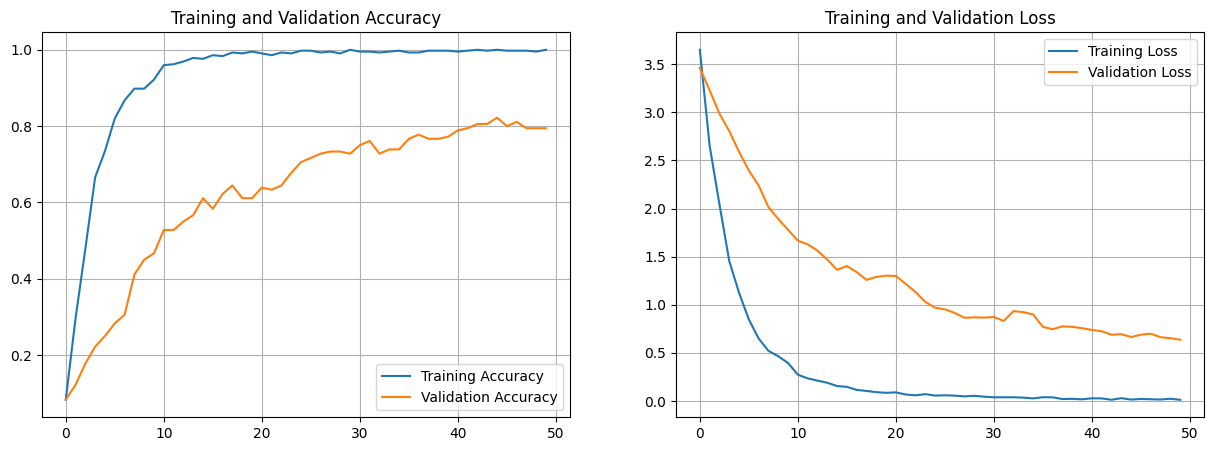

In [6]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 5))
    
    # 1. Biểu đồ Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)

    # 2. Biểu đồ Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid(True)
    
    plt.savefig('training_history.png')
    plt.show()

plot_training_history(history)

12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 399ms/step


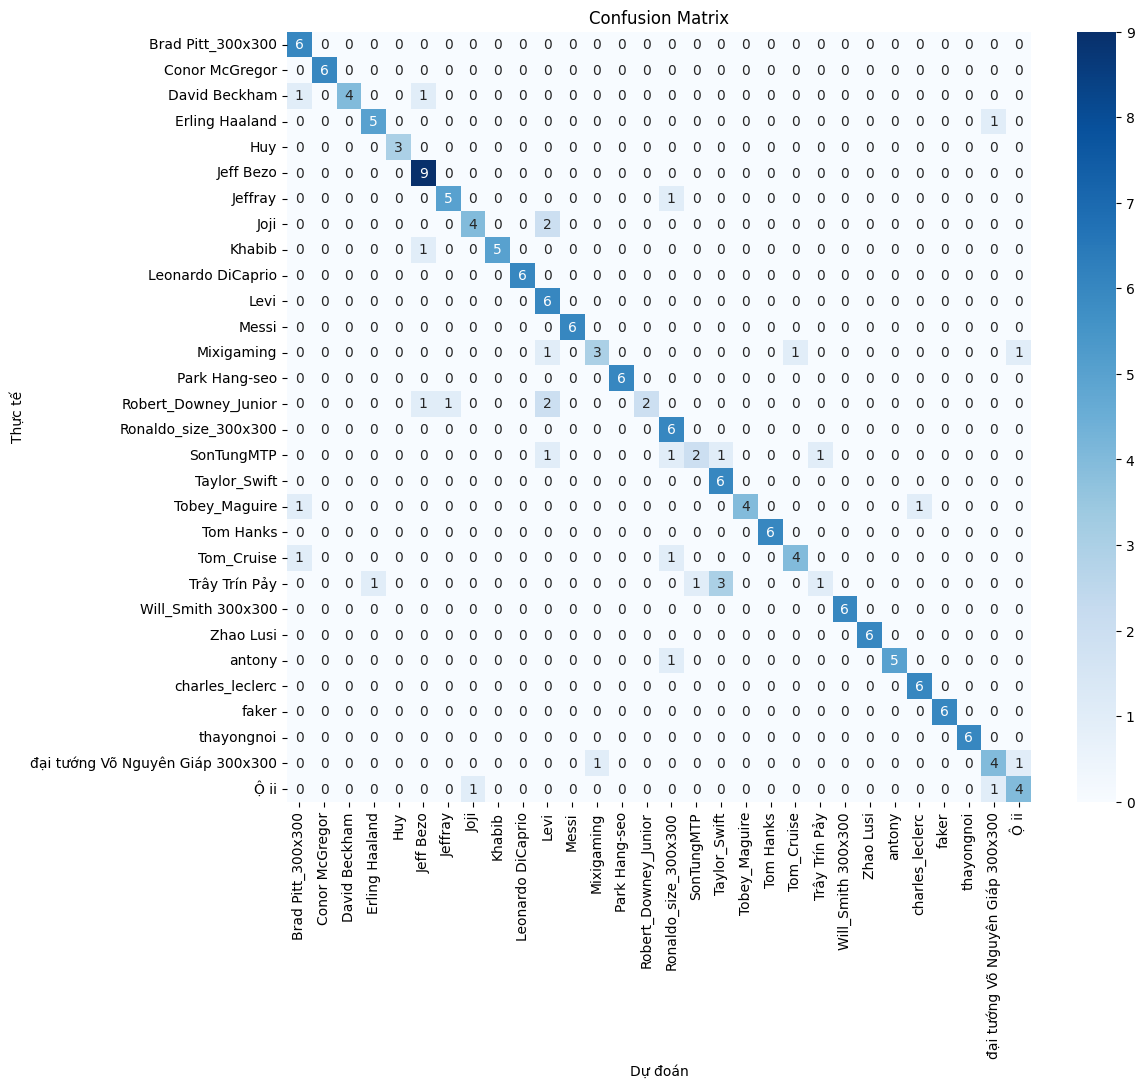

                                  precision    recall  f1-score   support

               Brad Pitt_300x300       0.67      1.00      0.80         6
                  Conor McGregor       1.00      1.00      1.00         6
                   David Beckham       1.00      0.67      0.80         6
                  Erling Haaland       0.83      0.83      0.83         6
                             Huy       1.00      1.00      1.00         3
                       Jeff Bezo       0.75      1.00      0.86         9
                         Jeffray       0.83      0.83      0.83         6
                            Joji       0.80      0.67      0.73         6
                          Khabib       1.00      0.83      0.91         6
               Leonardo DiCaprio       1.00      1.00      1.00         6
                            Levi       0.50      1.00      0.67         6
                           Messi       1.00      1.00      1.00         6
                      Mixigaming     

In [7]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load lại model tốt nhất
best_model = tf.keras.models.load_model(checkpoint_filepath)

# Dự đoán
validation_generator.reset()
Y_pred = best_model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_final.png')
plt.show()

# Report
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

In [8]:
import shutil

# 1. Nén folder Validation
print("Đang nén dữ liệu Validation...")
shutil.make_archive('validation_data', 'zip', '/kaggle/working/Processed_Dataset/val')

print(f"✅ Đã tạo file: validation_data.zip")
print(f"✅ File model: {checkpoint_filepath}")
print("Kiểm tra mục Output (Working Directory) để tải về.")

Đang nén dữ liệu Validation...
✅ Đã tạo file: validation_data.zip
✅ File model: best_face_model.keras
Kiểm tra mục Output (Working Directory) để tải về.


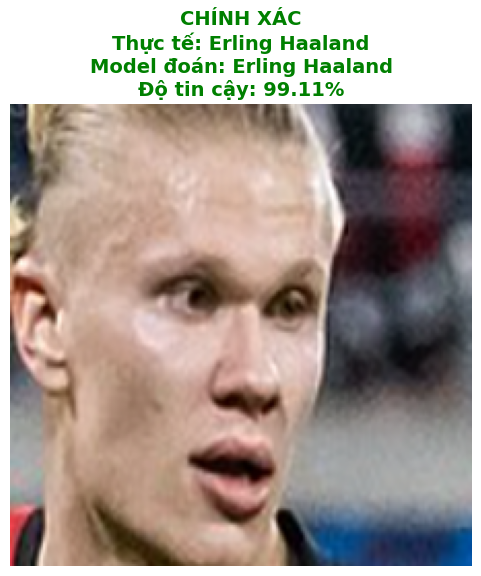

📂 Đường dẫn ảnh: /kaggle/working/Processed_Dataset/val/Erling Haaland/Screenshot 2025-12-18 160429.png
📊 Vector xác suất: [[1.500e-03 4.000e-04 0.000e+00 9.911e-01 0.000e+00 1.500e-03 0.000e+00
  1.000e-04 1.300e-03 6.000e-04 0.000e+00 3.000e-04 2.000e-04 6.000e-04
  0.000e+00 1.000e-03 0.000e+00 1.000e-04 0.000e+00 2.000e-04 1.000e-04
  0.000e+00 2.000e-04 0.000e+00 5.000e-04 0.000e+00 1.000e-04 0.000e+00
  0.000e+00 0.000e+00]]


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random
import os

# --- CẤU HÌNH ---


# best_model = tf.keras.models.load_model('best_face_model.keras')

def predict_random_image():
    # 1. Lấy danh sách tất cả các đường dẫn ảnh trong tập Valid
    # validation_generator.filepaths chứa toàn bộ đường dẫn ảnh
    # validation_generator.classes chứa nhãn thực tế (dạng số) tương ứng
    total_samples = validation_generator.samples
    random_index = random.randint(0, total_samples - 1)
    
    img_path = validation_generator.filepaths[random_index]
    true_label_index = validation_generator.classes[random_index]
    true_label = class_names[true_label_index] # Tên lớp thực tế
    
    # 2. Xử lý ảnh để đưa vào Model
    # Load ảnh và resize về 224x224
    img_original = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img_original)
    
    # Chuẩn hóa về [0, 1] giống hệt lúc train
    img_array = img_array / 255.0 
    
    # Thêm chiều batch (1, 224, 224, 3) vì model nhận đầu vào là batch
    img_batch = np.expand_dims(img_array, axis=0)
    
    # 3. Dự đoán
    prediction = best_model.predict(img_batch, verbose=0)
    pred_label_index = np.argmax(prediction) # Lấy vị trí có xác suất cao nhất
    pred_label = class_names[pred_label_index] # Tên lớp dự đoán
    confidence = np.max(prediction) * 100 # Độ tin cậy (%)
    
    # 4. Hiển thị kết quả
    plt.figure(figsize=(6, 6))
    plt.imshow(img_original)
    plt.axis('off') 
    
    # Logic hiển thị màu chữ:
    # - Màu Xanh (Green) nếu dự đoán ĐÚNG
    # - Màu Đỏ (Red) nếu dự đoán SAI
    if true_label == pred_label:
        color = 'green'
        result_text = "CHÍNH XÁC"
    else:
        color = 'red'
        result_text = "SAI"
        
    title_text = (f"{result_text}\n"
                  f"Thực tế: {true_label}\n"
                  f"Model đoán: {pred_label}\n"
                  f"Độ tin cậy: {confidence:.2f}%")
    
    plt.title(title_text, color=color, fontsize=14, fontweight='bold')
    plt.show()
    
    print(f"📂 Đường dẫn ảnh: {img_path}")
    print(f"📊 Vector xác suất: {np.round(prediction, 4)}")

# Gọi hàm để chạy
predict_random_image()